# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Processamento de Linguagem Natural</font>

## Word2vec Avançado

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


In [2]:
!nvidia-smi

Sat May 16 20:49:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0 Off |                  N/A |
| 23%   37C    P8     9W / 250W |    114MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   33C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Imports
import os
import csv
import random
import math
import collections
import bz2
import nltk
import numpy as np
import matplotlib
import tensorflow as tf
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
import sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from math import ceil
%matplotlib inline

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

sklearn          0.22.2
csv              1.0
tensorflow       2.2.0
numpy            1.18.4
matplotlib.pylab 1.18.4
nltk             3.4.5
matplotlib       3.2.1
Data Science Academy


In [6]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

## Dataset
Este código faz o download de um [conjunto de dados] (http://www.evanjones.ca/software/wikipedia2text.html) que consiste em vários artigos da Wikipedia, totalizando aproximadamente 61 megabytes. Além disso, o código garante que o arquivo tenha o tamanho correto após o download.

In [7]:
url = 'http://www.evanjones.ca/software/'

def maybe_download(filename, expected_bytes):
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Encontrado e verificado %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Não foi possível obter o arquivo ' + filename + '. Você pode fazer o download via browser?')
    return filename

filename = 'dados/wikipedia2text-extracted.txt.bz2'

## Leitura dos dados e pré-processamento com NLTK
Lê os dados como estão em uma string, converte em minúscula e o converte em tokens usando a biblioteca nltk. Esse código lê os dados em partes de 1 MB (pois o processamento do texto completo de uma só vez é muito lento) e retorna uma lista de palavras.

In [8]:
def read_data(filename):

    with bz2.BZ2File(filename) as f:

        data = []
        file_size = os.stat(filename).st_size
        chunk_size = 1024 * 1024
        print('Lendo os dados...')
        for i in range(ceil(file_size//chunk_size)+1):
            bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
            file_string = f.read(bytes_to_read).decode('utf-8')
            file_string = file_string.lower()
            file_string = nltk.word_tokenize(file_string)
            data.extend(file_string)
        return data

words = read_data(filename)
print('Data size %d' % len(words))
token_count = len(words)

print('Palavras de exemplo (start): ',words[:10])
print('Palavras de exemplo (end): ',words[-10:])

Lendo os dados...
Data size 3361041
Palavras de exemplo (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Palavras de exemplo (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


## Construindo os Dicionários
Para entender cada um desses elementos, vamos também assumir o texto "Eu gosto de ir à escola"

* `dictionary`: mapeia uma palavra para um ID (i.e. {Eu:0, gosto:1, de:2, ir:3, à:4, escola:5})
* `reverse_dictionary`: mapeia um ID para uma palavra (i.e. {0:Eu, 1:gosto, 2:de, 3:ir, 4:à, 5:escola}
* `count`: Lista de elementos (palavra, frequência) (i.e. [(Eu,1),(gosto,1),(de,2),(ir,1),(à,1),(escola,1)]
* `data` : Contém a string de texto que lemos, onde palavras são substituídas por IDs de palavras (i.e. [0, 1, 2, 3, 2, 4])

Também introduzimos um token especial adicional chamado `UNK` para indicar que palavras raras são muito raras para serem usadas.

In [9]:
# Nós restringimos o tamanho do nosso vocabulário para 50000
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]

  # Obtém apenas o vocabulary_size para palavras mais comuns como o vocabulário
  # Todas as outras palavras serão substituídas por token UNK
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()

  # Cria um ID para cada palavra, dando o comprimento atual do dicionário
  # e adicionando esse item ao dicionário
  for word, _ in count:
    dictionary[word] = len(dictionary)

  data = list()
  unk_count = 0

  # Percorrer todo o texto que temos e produzir uma lista onde cada elemento corresponde ao ID
  # da palavra encontrada nesse índice
  for word in words:
    # Se a palavra estiver no dicionário, use a palavra ID, senão use o ID do token especial "UNK"
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  # Atualiza a variável count com o número de ocorrências UNK
  count[0][1] = unk_count

  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

  # Verifica se o dicionário é do tamanho do vocabulário
  assert len(dictionary) == vocabulary_size

  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Palavras mais comuns (+UNK)', count[:5])
print('Dados de amostra', data[:10])
del words

Palavras mais comuns (+UNK) [['UNK', 68859], ('the', 226892), (',', 184013), ('.', 120944), ('of', 116323)]
Dados de amostra [1721, 9, 8, 16476, 223, 4, 5166, 4457, 26, 11592]


## Gerando Lotes de Dados para o Skip-Gram
Gera um lote ou palavras de destino (`batch`) e um lote de palavras de contexto correspondentes (`labels`). Ele lê as palavras `2 * window_size + 1` por vez (chamado` span`) e cria os datapoints `2 * window_size` em um único intervalo. A função continua dessa maneira até que os datapoints `batch_size` sejam criados. Toda vez que chegamos ao final da sequência de palavras, retornamos ao começo.

In [10]:
data_index = 0

def generate_batch_skip_gram(batch_size, window_size):
  # data_index é atualizado por 1 toda vez que lemos um ponto de dados
  global data_index

  # Dois arrays para conter as palavras-alvo (lote) e as palavras de contexto (etiquetas)
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

  # span define o tamanho total da janela, onde os dados que consideramos em uma instância
  # são exibidos da seguinte maneira: [skip_window target skip_window]
  span = 2 * window_size + 1

  # O buffer contém os dados contidos no intervalo
  buffer = collections.deque(maxlen=span)

  # Preenche o buffer e atualiza o data_index
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)

  # Este é o número de palavras de contexto que experimentamos para uma única palavra de destino
  num_samples = 2*window_size

  # Nós dividimos a leitura do lote em dois loops for
  # O loop interno preenche o lote e os rótulos com
  # num_samples pontos de dados usando dados contidos no intervalo
  # O loop externo é repetido por batch_size // num_samples times
  # para produzir um lote completo
  for i in range(batch_size // num_samples):
    k=0

    # Evita a própria palavra alvo como uma previsão
    # Preenchimento de matrizes de lotes e rótulos numpy
    for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
      batch[i * num_samples + k] = buffer[window_size]
      labels[i * num_samples + k, 0] = buffer[j]
      k += 1

    # Toda vez que lemos num_samples pontos de dados,
    # criamos o número máximo de pontos de dados possíveis
    # com um único intervalo, por isso precisamos mover o span por 1
    # para criar um novo intervalo
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('Dados:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_skip_gram(batch_size=8, window_size=window_size)
    print('\nCom window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

Dados: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

Com window_size = 1:
    batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
    labels: ['propaganda', 'a', 'is', 'concerted', 'a', 'set', 'concerted', 'of']

Com window_size = 2:
    batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
    labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']


## Algoritmo Skip-Gram original
O algoritmo skip-gram original não possuía uma camada oculta, mas calculava a perda das próprias embeddings. Portanto, o algoritmo skip-gram tinha duas camadas de embeddings diferentes, uma para entradas e outra para saídas.

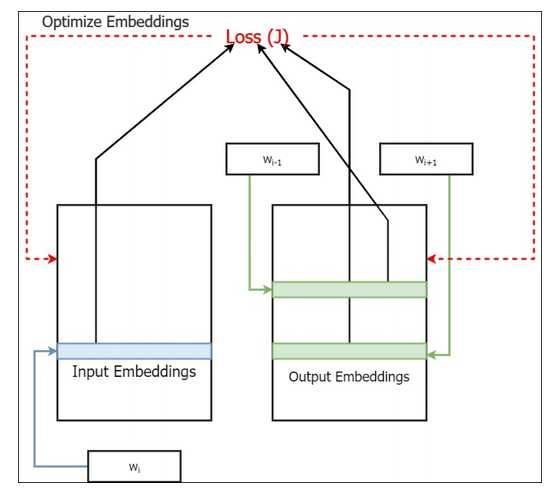

In [11]:
from IPython.display import Image
Image("images/original-skip-gram.png")

### Definindo Hiperparâmetros

Aqui nós definimos vários hiperparâmetros incluindo 

- `batch_size` (quantidade de amostras em um único lote) 
- `embedding_size` (tamanho dos embedding vectors) 
- `window_size` (tamanho da janela de contexto).

In [12]:
# Pontos de dados em um único lote
batch_size = 128

# Dimensão do embedding vector.
embedding_size = 128

# Quantas palavras considerar à esquerda e à direita.
window_size = 4

# Nós escolhemos um conjunto de validação aleatório para testar os vizinhos mais próximos
# Conjunto aleatório de palavras para avaliar a similaridade.
valid_size = 16

# Nós experimentamos datapoints válidos aleatoriamente a partir de uma janela grande sem sermos sempre determinísticos
valid_window = 50

# Ao selecionar exemplos válidos, selecionamos algumas das palavras mais frequentes,
# bem como algumas palavras moderadamente raras
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

# Número de exemplos negativos para amostra.
num_sampled = 32

### Definindo Entradas e Saídas

Aqui nós definimos espaços reservados (placeholders) para alimentação dos dados de entrada e saída para o treinamento (cada um de tamanho `batch_size`) e um tensor constante para conter exemplos de validação.

In [13]:
tf.compat.v1.reset_default_graph()

# Dados de entrada de treinamento (IDs de palavras de destino).
train_dataset = tf.compat.v1.placeholder(tf.int32, shape=[batch_size])

# Dados de labels de entrada de treinamento (IDs de palavras de contexto)
train_labels = tf.compat.v1.placeholder(tf.int64, shape=[batch_size, 1])

# Dados de entrada de validação, não precisamos de um espaço reservado,
# pois já definimos os IDs das palavras selecionadas como dados de validação
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Definindo Parâmetros do Modelo e Outras Variáveis
Nós agora definimos diversas variáveis do TensorFlow, como uma camada embeddings (`embeddings`) e parâmetros de rede neural (`softmax_weights` e `softmax_biases`)

In [14]:
# Variables

# Embedding layers, contém a word embeddings
# Nós definimos duas camadas de embeddings
# in_embeddings é usado para procurar por embeddings correspondentes a palavras-alvo (entradas)
in_embeddings = tf.Variable(tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# out_embeddings é usado para pesquisar em embeddings correspondentes a palavras de contexto (rótulos)
out_embeddings = tf.Variable(tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0))

### Definindo as Computações Modelo

Aqui definimos várias operações do TensorFlow necessárias para computar a perda e as previsões. Primeiro, definimos uma operação para buscar amostras negativas para um determinado lote de dados. Em seguida, definimos funções de pesquisa de embeddings para os dados true (`in_embed` e` out_embed`) e negativos (`negative_embed`) onde essas operações buscam os vetores de embeddings correspondentes para um conjunto de entradas dadas. Com isso, definimos a perda de amostragem negativa manualmente usando as integrações retornadas pelas pesquisas.

In [15]:
# 1. Computa amostras negativas para um determinado lote de dados
# Retorna um tensor de tamanho [num_samples]
negative_samples, _, _ = tf.random.log_uniform_candidate_sampler(train_labels, num_true=1, num_sampled=num_sampled,
                                                           unique=True, range_max=vocabulary_size)

# 2. Procura por embeddings para entradas, saídas e amostras negativas.
in_embed = tf.nn.embedding_lookup(params=in_embeddings, ids=train_dataset)
out_embed = tf.nn.embedding_lookup(params=out_embeddings, ids=tf.reshape(train_labels,[-1]))
negative_embed = tf.nn.embedding_lookup(params=out_embeddings, ids=negative_samples)

# 3. Definição manual de perda negativa de amostra
# Como o Tensorflow tem uma quantidade limitada de flexibilidade na função sampled_softmax_loss integrada,
# temos que definir manualmente a função de perda.

# 3.1. Calculando a perda para a amostra positiva
# log(sigma(v_o * v_i^T))
loss = tf.reduce_mean(
  input_tensor=tf.math.log(
      tf.nn.sigmoid(
          tf.reduce_sum(
              input_tensor=tf.linalg.tensor_diag([1.0 for _ in range(batch_size)])*
              tf.matmul(out_embed,tf.transpose(a=in_embed)),
          axis=0)
      )
  )
)

# 3.2. Computando a perda para as amostras negativas
# Nós computamos sum(log (sigma (-v_no * v_i ^ T))) com o seguinte:
# Nota: A maneira exata como esta parte é computada na biblioteca do TensorFlow parece ser
# tomando apenas os pesos correspondentes a amostras verdadeiras e amostras negativas
# e depois computando o softmax_cross_entropy_with_logits para esse subconjunto de pesos.
# Mais informações em: https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/ops/nn_impl.py
# Embora a abordagem seja diferente, a ideia continua a mesma
loss += tf.reduce_mean(
  input_tensor=tf.reduce_sum(
      input_tensor=tf.math.log(tf.nn.sigmoid(-tf.matmul(negative_embed,tf.transpose(a=in_embed)))),
      axis=0
  )
)

# O acima é a probabilidade do log.
# Gostaríamos de transformar isso em probabilidade de log negativo
# para converter isso em perda. Isso nos fornece
# L = - (log(sigma(v_o * v_i^T))+sum(log(sigma(-v_no * v_i^T))))
loss *= -1.0

### Calculando Similaridade de palavras
Calculamos a similaridade entre duas palavras dadas em termos da distância do cosseno. Para fazer isso de maneira eficiente, usamos operações de matriz para fazer isso, conforme mostrado abaixo.

In [16]:
# Calcula a similaridade entre os exemplos de minibatch e todos os embeddings.
# Nós usamos a distância do cosseno:
norm = tf.sqrt(tf.reduce_sum(input_tensor=tf.square((in_embeddings+out_embeddings)/2.0), axis=1, keepdims=True))
normalized_embeddings = out_embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
params=normalized_embeddings, ids=valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(a=normalized_embeddings))

### Otimizador de Parâmetros do Modelo

Em seguida, definimos uma taxa de aprendizado constante e um otimizador que usa o método Adagrad. Sinta-se à vontade para experimentar outros otimizadores listados [aqui] (https://www.tensorflow.org/api_guides/python/train).

In [17]:
# Otimizador
optimizer = tf.compat.v1.train.AdagradOptimizer(1.0).minimize(loss)

## Treinando o Algoritmo Skip-Gram

Aqui executamos o algoritmo skip-gram original que definimos acima. Especificamente, primeiro inicializamos as variáveis e depois treinamos o algoritmo para várias etapas (`num_steps`). E a cada poucos passos avaliamos o algoritmo em um conjunto de validação fixo e imprimimos as palavras que parecem estar mais próximas de um determinado conjunto de palavras.

In [18]:
num_steps = 100001

# Coleta os valores de perda sequencial para fins de plotagem
skip_gram_loss_original = []

# ConfigProto é uma maneira de fornecer várias configurações necessárias para executar o grafo
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as session:

  # Inicializa as variáveis no grafo
  tf.compat.v1.global_variables_initializer().run()
  print('Variáveis Inicializadas')
  average_loss = 0

  # Treina o modelo Word2vec para iterações num_step
  for step in range(num_steps):

    # Gera um único lote de dados
    batch_data, batch_labels = generate_batch_skip_gram(
      batch_size, window_size)

    # Preenche o feed_dict, executa o otimizador (minimize loss) e calcule a perda
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)

    # Atualiza a variável de perda média
    average_loss += l

    if (step+1) % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000

      # A perda média é uma estimativa da perda nos últimos 2000 lotes.
      print('Erro Médio no Passo %d: %f' % (step+1, average_loss))
      skip_gram_loss_original.append(average_loss)
      average_loss = 0

    # Avaliação de simlaridade de palavras do conjunto de validação
    if (step+1) % 10000 == 0:
      sim = similarity.eval()

      # Aqui nós calculamos as palavras top_k mais próximas para uma dada palavra de validação
      # em termos da distância cosseno. Fazemos isso para todas as palavras no conjunto de validação.
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Mais Próximo da palavra %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)

  skip_gram_original_final_embeddings = normalized_embeddings.eval()
np.save('skip_original_embeddings',skip_gram_original_final_embeddings)

with open('dados/skip_original_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skip_gram_loss_original)

Variáveis Inicializadas
Erro Médio no Passo 2000: 22.990921
Erro Médio no Passo 4000: 14.925494
Erro Médio no Passo 6000: 12.197328
Erro Médio no Passo 8000: 10.788457
Erro Médio no Passo 10000: 9.478359
Mais Próximo da palavra were: UNK, in, of, and, from, is, ., the,
Mais Próximo da palavra that: in, ., UNK, is, of, and, the, ,,
Mais Próximo da palavra ;: UNK, in, and, ., of, from, ,, for,
Mais Próximo da palavra its: UNK, in, of, and, is, ., as, the,
Mais Próximo da palavra and: UNK, ., in, ,, of, the, is, as,
Mais Próximo da palavra at: at, ., of, in, is, and, the, ,,
Mais Próximo da palavra first: in, UNK, and, ., as, of, is, the,
Mais Próximo da palavra this: UNK, and, in, ., a, as, ,, is,
Mais Próximo da palavra one: UNK, ., and, is, of, ,, in, the,
Mais Próximo da palavra been: UNK, ., is, in, and, of, (, as,
Mais Próximo da palavra have: UNK, in, ., of, and, ,, the, is,
Mais Próximo da palavra (: UNK, ., in, of, and, ,, the, is,
Mais Próximo da palavra had: UNK, and, in, ., ,,

Erro Médio no Passo 72000: 5.219337
Erro Médio no Passo 74000: 5.285506
Erro Médio no Passo 76000: 4.999783
Erro Médio no Passo 78000: 4.970548
Erro Médio no Passo 80000: 4.885253
Mais Próximo da palavra were: ., which, for, in, 's, by, from, is,
Mais Próximo da palavra that: is, a, which, but, from, that, by, in,
Mais Próximo da palavra ;: ., is, a, by, from, 's, which, in,
Mais Próximo da palavra its: ., a, is, from, which, in, by, 's,
Mais Próximo da palavra and: and, a, in, for, 's, is, from, by,
Mais Próximo da palavra at: ., from, a, is, 's, the, or, in,
Mais Próximo da palavra first: ., by, is, in, which, 's, for, or,
Mais Próximo da palavra this: ., is, a, for, by, from, the, in,
Mais Próximo da palavra one: ., a, 's, the, is, for, from, which,
Mais Próximo da palavra been: a, is, been, which, by, from, for, on,
Mais Próximo da palavra have: is, have, which, from, has, a, for, by,
Mais Próximo da palavra (: UNK, a, 's, is, from, or, in, and,
Mais Próximo da palavra had: in, for

## Plotting Skip Gram Loss vs Original Skip Gram Loss
Aqui nós plotamos a perda do modelo skip-gram que criamos do capítulo anterior com a perda original do skip-gram que acabamos de executar para ver qual deles tem melhor desempenho.

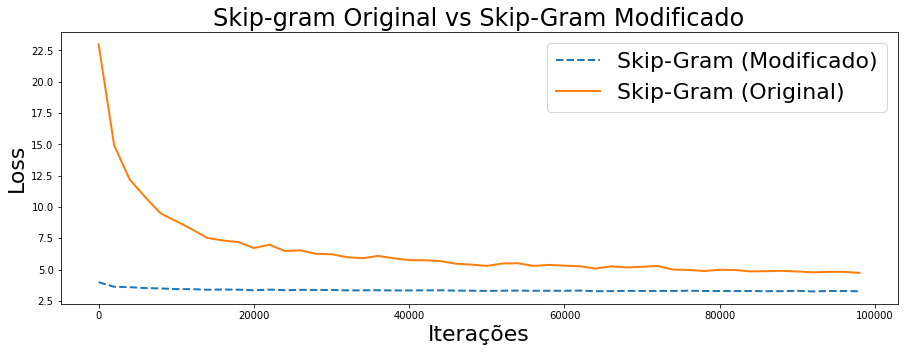

In [19]:
# Carrega o modelo criado no capítulo anterior
skip_loss_path = os.path.join('arquivos_cap06','skip-gram_losses.csv')

with open(skip_loss_path, 'rt') as f:
    reader = csv.reader(f,delimiter=',')
    for r_i,row in enumerate(reader):
        if r_i == 0:
            skip_gram_loss =  [float(s) for s in row]


pylab.figure(figsize=(15,5))

# Eixo x
x = np.arange(len(skip_gram_loss))*2000

# Plot do modelo Skip-gram modificado (criado no capítulo 6)
pylab.plot(x, skip_gram_loss, label="Skip-Gram (Modificado)",linestyle='--',linewidth=2)

# Plot do modelo Skip-gram original
pylab.plot(x, skip_gram_loss_original, label="Skip-Gram (Original)",linewidth=2)

# Legenda
pylab.title('Skip-gram Original vs Skip-Gram Modificado',fontsize=24)
pylab.xlabel('Iterações',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)

# Salva o Plot
pylab.savefig('images/loss_skipgram_original_vs_modificado.jpg')
pylab.show()

## Plotting Skip-Gram Loss vs CBOW Loss

Aqui nós comparamos a perda do skip-gram e a perda de CBOW para comparar qual perda diminui mais rapidamente. 

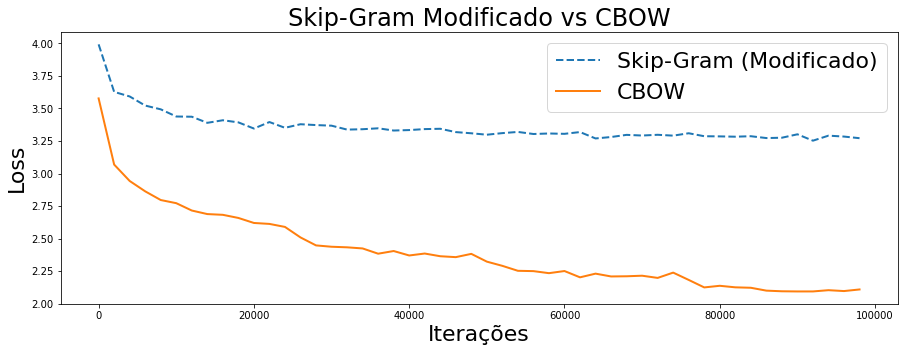

In [20]:
# # Carrega o modelo CBOW criado no capítulo anterior
cbow_loss_path = os.path.join('arquivos_cap06','cbow_losses.csv')

with open(cbow_loss_path, 'rt') as f:
    reader = csv.reader(f,delimiter=',')
    for r_i,row in enumerate(reader):
        if r_i == 0:
            cbow_loss =  [float(s) for s in row]

pylab.figure(figsize=(15,5))

# Eixo x
x = np.arange(len(skip_gram_loss))*2000

# Plot do modelo Skip-gram modificado
pylab.plot(x, skip_gram_loss, label="Skip-Gram (Modificado)",linestyle='--',linewidth=2)

# Plot do modelo CBOW (criado no capítulo anterior)
pylab.plot(x, cbow_loss, label="CBOW",linewidth=2)

# Legenda
pylab.title('Skip-Gram Modificado vs CBOW',fontsize=24)
pylab.xlabel('Iterações',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)

# Salva o Plot
pylab.savefig('images/loss_skipgram_vs_cbow.png')
pylab.show()

## Plotting TSNE Embeddings Para Skip-Gram e CBOW Lado a Lado

A perda em si não é uma medida adequada de desempenho. Portanto, visualizamos as embeddings aprendidas projetando as embeddings em uma tela bidimensional com uma técnica conhecida como t-SNE.

t-Distributed Stochastic Neighbor Embedding (t-SNE) é uma técnica (ganhadora de prêmios) para redução de dimensionalidade que é particularmente adequada para a visualização de conjuntos de dados de alta dimensão. A técnica pode ser implementada via aproximações do Barnes-Hut, permitindo que ela seja aplicada em grandes conjuntos de dados do mundo real. 

O t-SNE é uma ferramenta para visualizar dados de alta dimensão. Converte semelhanças entre pontos de dados para probabilidades conjuntas e tenta minimizar a divergência de Kullback-Leibler entre as probabilidades conjuntas da incorporação de baixa dimensão e os dados de alta dimensão. O t-SNE tem uma função de custo que não é convexa, ou seja, com diferentes inicializações, podemos obter resultados diferentes.

É altamente recomendado usar outro método de redução de dimensionalidade (por exemplo, PCA para dados densos ou TruncatedSVD para dados esparsos) para reduzir o número de dimensões para uma quantidade razoável (por exemplo, 50) se o número de características for muito alto.

In [21]:
def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    '''
    Encontra apenas os agrupamentos próximos.
    Isso elimina os embeddings de palavra mais esparsamente distribuídos e torna a visualização mais clara.
    Isso é útil para a visualização de t-SNE.

    distance_threshold: distância máxima entre dois pontos para se qualificar como vizinhos
    sample_threshold: número de vizinhos requeridos para serem considerados um cluster
    '''

    # Calcular a similaridade de cosseno
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm

    # Faz todas as entradas na diagonal zero; caso contrário, isso será escolhido como maior
    np.fill_diagonal(cosine_sim, -1.0)

    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim

    # Encontra os máximos em um loop para contar se houver mais de n itens acima do limite
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1

    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

### Fitting Skip-gram e CBOW embeddings para o t-SNE 

Ajustamos os embeddings Skip-gram e CBOW a um t-SNE para obter seu mapeamento em uma superfície bidimensional. Visualizamos apenas pontos de dados densamente agrupados para evitar confusão na visualização. Isto é conseguido com a função acima `find_clustered_embeddings`.

In [22]:
# Carregando os 2 modelos criados no capítulo anterior
skip_emb_path = os.path.join('arquivos_cap06','skip-gram_embeddings.npy')
cbow_emb_path = os.path.join('arquivos_cap06','cbow_embeddings.npy')

skip_gram_final_embeddings = np.load(skip_emb_path)
cbow_final_embeddings = np.load(cbow_emb_path)

# Usaremos um grande espaço de amostra para construir o manifold T-SNE e, em seguida, podá-lo usando semelhança de cosseno
num_points = 1000

# Cria um objeto t-SNE a partir do scikit-learn
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings Para o T-SNE (Skip-gram e CBOW)')

# Obtenha o manifold T-SNE para embeddings skip-gram
print('\tSkip-gram')
sg_selected_embeddings = skip_gram_final_embeddings[:num_points, :]
sg_two_d_embeddings = tsne.fit_transform(sg_selected_embeddings)

# Obtenha o manifold T-SNE para embeddings CBOW
print('\tCBOW')
cbow_selected_embeddings = cbow_final_embeddings[:num_points, :]
cbow_two_d_embeddings = tsne.fit_transform(cbow_selected_embeddings)

print('Pruning T-SNE embeddings (Skip-gram e CBOW)')

# Pruning os embeddings, obtendo apenas mais do que n-muitos exemplos acima do limiar de semelhança
# isto desobstrui a visualização

# Prune skip-gram
print('\tSkip-gram')
sg_selected_ids = find_clustered_embeddings(sg_selected_embeddings,.3,10)
sg_two_d_embeddings = sg_two_d_embeddings[sg_selected_ids,:]

# Prune CBOW
print('\tCBOW')
cbow_selected_ids = find_clustered_embeddings(cbow_selected_embeddings,.3,10)
cbow_two_d_embeddings = cbow_two_d_embeddings[cbow_selected_ids,:]

# Some stats about pruning
print('Cerca de ',num_points,' amostras (skip-gram), ', sg_selected_ids.shape[0],' foram selecionadas por pruning')
print('Cerca de ',num_points,' amostras (CBOW), ', cbow_selected_ids.shape[0],' foram selecionadas por pruning')


Fitting embeddings Para o T-SNE (Skip-gram e CBOW)
	Skip-gram
	CBOW
Pruning T-SNE embeddings (Skip-gram e CBOW)
	Skip-gram
	CBOW
Cerca de  1000  amostras (skip-gram),  114  foram selecionadas por pruning
Cerca de  1000  amostras (CBOW),  134  foram selecionadas por pruning


### Plotting the Embeddings
Aqui nós plotamos as embeddings lado a lado, cada camada de embeddings em seu subplot próprio. Também usamos cores diferentes para pontos de dados para melhorar a clareza.

Define Label colors for %d 20
Executando K-Means para skip-gram


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Executando K-Means for CBOW
K-Means executado com sucesso
Plot dos resultados


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


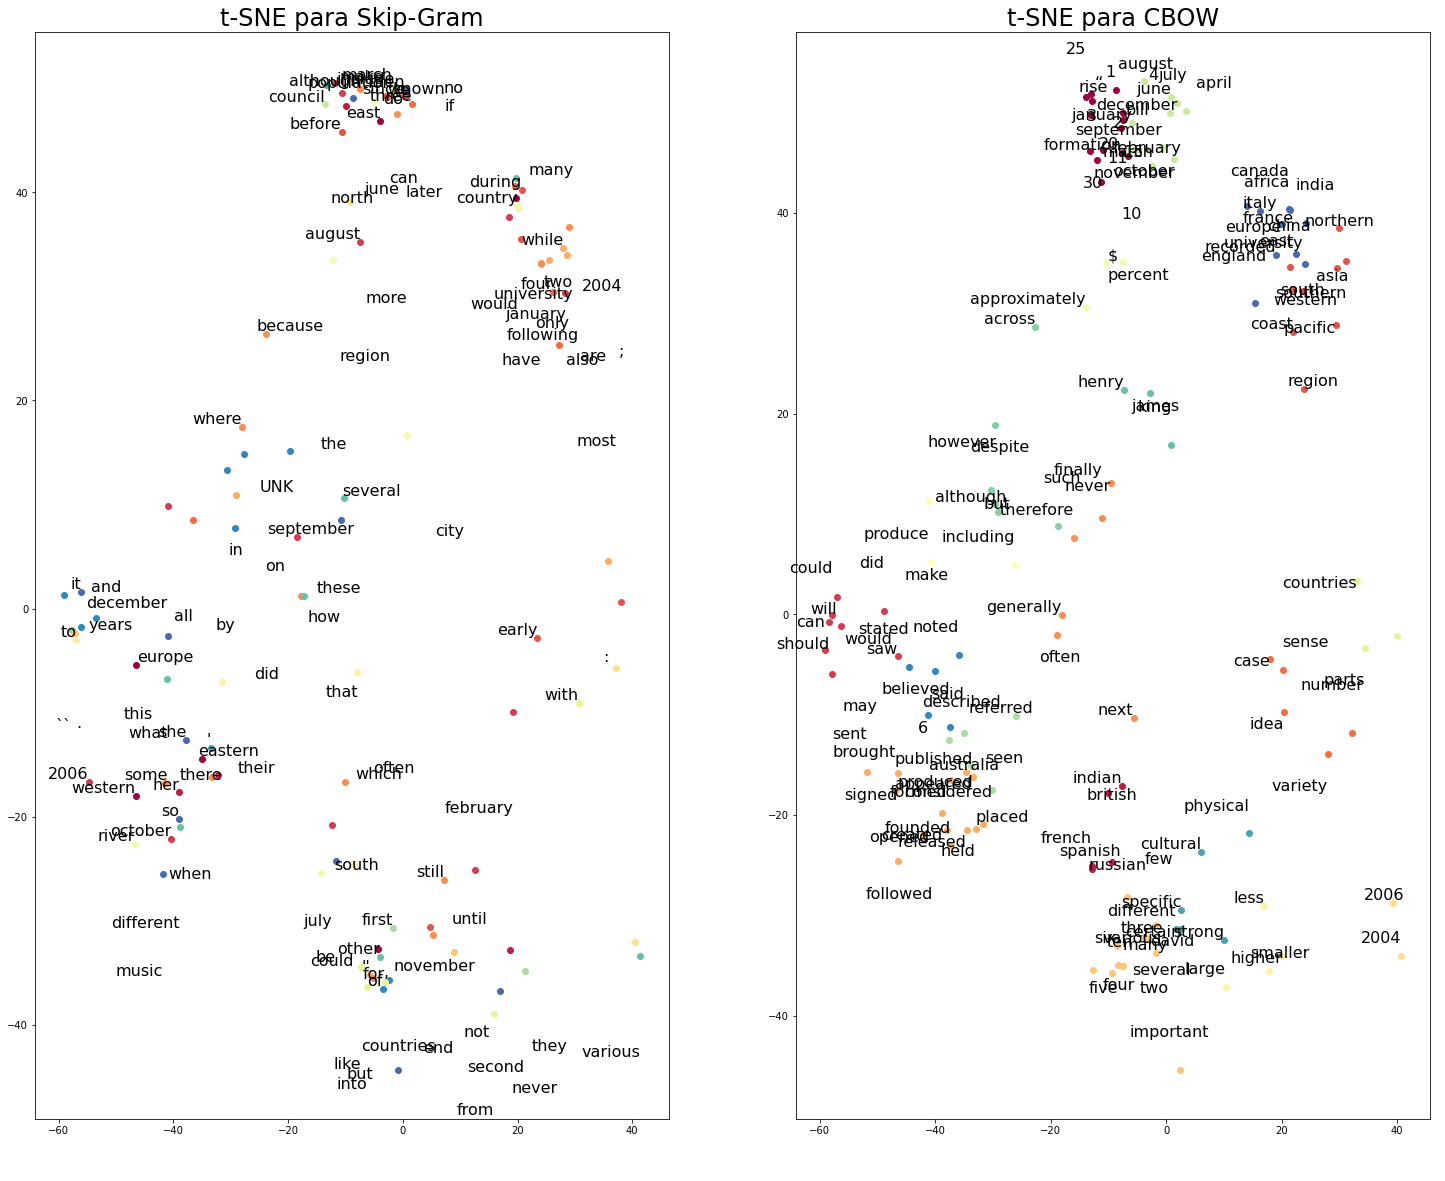

In [23]:
def plot_embeddings_side_by_side(sg_embeddings, cbow_embeddings, sg_labels, cbow_labels):

  # Número de clusters para cada word embedding
  # Clustering é usado para atribuir cores diferentes como um auxílio visual
  n_clusters = 20

  # Constrói automaticamente um conjunto discreto de cores, cada uma para o cluster
  print('Define Label colors for %d',n_clusters)
  cmap = pylab.cm.get_cmap("Spectral")
  label_colors = [cmap(float(i) /n_clusters) for i in range(n_clusters)]

  # Verifique se o número de embeddings e seus rótulos são os mesmos
  assert sg_embeddings.shape[0] >= len(sg_labels), 'Mais labels que embeddings'
  assert cbow_embeddings.shape[0] >= len(cbow_labels), 'Mais labels que embeddings'

  print('Executando K-Means para skip-gram')

  # Define K-Means
  sg_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(sg_embeddings)
  sg_kmeans_labels = sg_kmeans.labels_
  sg_cluster_centroids = sg_kmeans.cluster_centers_

  print('Executando K-Means for CBOW')
  cbow_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(cbow_embeddings)
  cbow_kmeans_labels = cbow_kmeans.labels_
  cbow_cluster_centroids = cbow_kmeans.cluster_centers_

  print('K-Means executado com sucesso')

  print('Plot dos resultados')
  pylab.figure(figsize=(25,20))  # in inches

  # Obter o primeiro subplot
  pylab.subplot(1, 2, 1)

  # Plot de todos os embeddings e suas palavras correspondentes para skip-gram
  for i, (label,klabel) in enumerate(zip(sg_labels,sg_kmeans_labels)):
    center = sg_cluster_centroids[klabel,:]
    x, y = cbow_embeddings[i,:]

    if x < center[0]:
        x += -abs(np.random.normal(scale=2.0))
    else:
        x += abs(np.random.normal(scale=2.0))

    if y < center[1]:
        y += -abs(np.random.normal(scale=2.0))
    else:
        y += abs(np.random.normal(scale=2.0))

    pylab.scatter(x, y, c=label_colors[klabel])
    x = x if np.random.random()<0.5 else x + 10
    y = y if np.random.random()<0.5 else y - 10
    pylab.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom',fontsize=16)
  pylab.title('t-SNE para Skip-Gram',fontsize=24)

  pylab.subplot(1, 2, 2)

  # Plote todos os embeddings e suas palavras correspondentes para CBOW
  for i, (label,klabel) in enumerate(zip(cbow_labels,cbow_kmeans_labels)):
    center = cbow_cluster_centroids[klabel,:]
    x, y = cbow_embeddings[i,:]

    if x < center[0]:
        x += -abs(np.random.normal(scale=2.0))
    else:
        x += abs(np.random.normal(scale=2.0))

    if y < center[1]:
        y += -abs(np.random.normal(scale=2.0))
    else:
        y += abs(np.random.normal(scale=2.0))

    pylab.scatter(x, y, c=label_colors[klabel])
    x = x if np.random.random()<0.5 else x + np.random.randint(0,10)
    y = y + np.random.randint(0,5) if np.random.random()<0.5 else y - np.random.randint(0,5)
    pylab.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom',fontsize=16)

  pylab.title('t-SNE para CBOW',fontsize=24)
  # use for saving the figure if needed
  pylab.savefig('images/tsne_skip_vs_cbow.png')
  pylab.show()

# Executa a função
sg_words = [reverse_dictionary[i] for i in sg_selected_ids]
cbow_words = [reverse_dictionary[i] for i in cbow_selected_ids]
plot_embeddings_side_by_side(sg_two_d_embeddings, cbow_two_d_embeddings, sg_words,cbow_words)

# Extensões Para Algoritmos Word Embedding

O artigo original de Mikolov, publicado em 2013, discute várias extensões que podem melhorar ainda mais o desempenho dos algoritmos de aprendizado das word embeddings. Embora eles tenham sido introduzidos inicialmente para serem usados para o Skip-gram, eles também são extensíveis ao CBOW. Além disso, como já vimos que o CBOW supera o algoritmo Skip-gram em nosso exemplo, usaremos o CBOW para entender todas as extensões.

Verificou-se que os resultados de desempenho da amostragem negativa são melhores quando realizados por amostragem de certas distribuições, em vez de pela distribuição uniforme. Uma dessas distribuições é a distribuição de unigramas. A probabilidade de unigrama de uma palavra wi é dada pela seguinte equação:

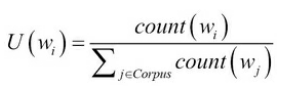

In [24]:
from IPython.display import Image
Image("images/unigram_prob.png")

Aqui, count (wi) é o número de vezes que o wi aparece no documento. Quando a distribuição de unigramas é distorcida como para alguma constante Z, ela mostra um melhor desempenho do que a distribuição uniforme ou a distribuição de unigrama padrão.

Vamos usar um exemplo para entender melhor a distribuição de unigrama. Considere as seguintes frases: 

Bob é fã de futebol. Ele está no time de futebol escolar. 

Aqui, a probabilidade de unigrama da palavra futebol seria a seguinte: U(futebol) = 2/12 = 1/6

Pode ser visto que a probabilidade de unigrama para palavras comuns será maior. Essas palavras comuns tendem a ser palavras muito pouco informativas, como o, a e é. 

Portanto, tais palavras frequentes serão amostradas negativamente mais durante a otimização de custos, enquanto as palavras mais informativas serão menos negativamente amostradas. Consequentemente, isso cria um equilíbrio entre as palavras comuns e palavras raras durante a otimização, levando a um melhor desempenho.

## Alterando o processo de geração de dados

Precisamos definir um novo gerador de dados para o CBOW. A forma da nova matriz de entrada é (batch_size, context_window * 2). Ou seja, um lote no CBOW captura todas as palavras no contexto de uma determinada palavra.

In [25]:
data_index = 0

def generate_batch_cbow(batch_size, window_size):

    global data_index

    span = 2 * window_size + 1

    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    buffer = collections.deque(maxlen=span)

    # Preenche o buffer e atualize o data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # Aqui nós fazemos a leitura do lote
    # Nós iteramos através de cada índice de lote
    # Para cada índice de lote, iteramos pelos elementos de intervalo
    # para preencher as colunas da matriz de lotes
    for i in range(batch_size):
        target = window_size
        target_to_avoid = [ window_size ]

        # Adiciona o alvo selecionado para avoid_list da próxima vez
        col_idx = 0
        for j in range(span):

            # Ignora a palavra alvo ao criar o lote
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j]
            col_idx += 1
        labels[i, 0] = buffer[target]

        # Toda vez que lemos um ponto de dados,
        # precisamos mover o span por 1
        # para criar um novo intervalo
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window_size=window_size)
    print('\nCom window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


Com window_size = 1:
    batch: [['propaganda', 'a'], ['is', 'concerted'], ['a', 'set'], ['concerted', 'of'], ['set', 'messages'], ['of', 'aimed'], ['messages', 'at'], ['aimed', 'influencing']]
    labels: ['is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']

Com window_size = 2:
    batch: [['propaganda', 'is', 'concerted', 'set'], ['is', 'a', 'set', 'of'], ['a', 'concerted', 'of', 'messages'], ['concerted', 'set', 'messages', 'aimed'], ['set', 'of', 'aimed', 'at'], ['of', 'messages', 'at', 'influencing'], ['messages', 'aimed', 'influencing', 'the'], ['aimed', 'at', 'the', 'opinions']]
    labels: ['a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']


# Usando Candidate Sampling Com Unigram Distribution Para Negative Sampling

## Unigram Distribution
A distirbuição unigrama $U(w_i)$ para uma data palavra $w_i$ é definida por,

$ P(w_i|w_1,...,w_{i-1}) \simeq P(w_i) = \frac{count(w_i)}{\sum_{w_j \in corpus}count(w_j)} = U(w_i) $

O artigo original descobriu que, se as palavras são amostradas, o ruído para a amostragem negativa com uma distribuição particular dá os melhores resultados. E a distribuição é dada por,

$ U(w)^{3/4} / Z $ onde $Z$ é uma constante.

In [26]:
# Criando arquivo de vocabulário e contagens de unigrama

# arquivo de vocabulário:
# Cada linha válida neste arquivo (que deve ter um formato semelhante a CSV) corresponde a um ID de palavra válido.
# IDs estão em ordem sequencial.

# Unigramas:
# Uma lista de contagens ou probabilidades de unigramas, uma por ID em ordem sequencial.
# Exatamente um dos arquivos vocab_file e unigrams deve ser passado para esta operação.
word_count_dictionary = {}
unigrams = [0 for _ in range(vocabulary_size)]
for word,w_count in count:
    w_idx = dictionary[word]
    unigrams[w_idx] = w_count*1.0/token_count
    word_count_dictionary[w_idx] = w_count
print('Primeiros 10 Unigram probabilities')
print(unigrams[:10])

Primeiros 10 Unigram probabilities
[0.020487402563670005, 0.0675064660026462, 0.054748811454546374, 0.035984089453237854, 0.034609217798890285, 0.026372484001236523, 0.023148482865873996, 0.019528770996842942, 0.017547242059826107, 0.00918108407484467]


### Definindo os Hiperparâmetros

Aqui nós definimos vários hiperparâmetros incluindo:

- `batch_size` (quantidade de amostras em um único lote)
- `embedding_size` (tamanho dos vetores embedding) 
- `window_size` (tamanho da janela de contexto).

In [27]:
# Pontos de dados em um único lote
batch_size = 128

# Dimensão do embedding vector.
embedding_size = 128

# Quantas palavras considerar à esquerda e à direita.
window_size = 2

# Nós escolhemos um conjunto de validação aleatório para testar os vizinhos mais próximos
# Conjunto aleatório de palavras para avaliar a similaridade.
valid_size = 16

# Nós experimentamos datapoints válidos aleatoriamente a partir de uma janela grande sem sermos sempre determinísticos
valid_window = 50

# Ao selecionar exemplos válidos, selecionamos algumas das palavras mais frequentes,
# bem como algumas palavras moderadamente raras
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

# Número de exemplos negativos para amostra.
num_sampled = 32

### Definindo Entradas e Saídas

Aqui nós definimos espaços reservados (placeholders) para alimentação dos dados de entrada e saída no treinamento (cada um dos tamanhos `batch_size`) e um tensor constante para conter exemplos de validação.

In [28]:
tf.compat.v1.reset_default_graph()

# Dados de entrada de treinamento (IDs de palavras de destino).
train_dataset = tf.compat.v1.placeholder(tf.int32, shape=[batch_size,2*window_size])

# Dados de etiqueta de entrada de treinamento (IDs de palavras de contexto)
train_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, 1])

# Dados de entrada de validação, não precisamos de um espaço reservado,
# pois já definimos os IDs das palavras selecionadas como dados de validação
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Definindo Parâmetros do Modelo e Outras Variáveis
Nós agora definimos várias variáveis do TensorFlow, como uma camada embeddings (`embeddings`) e parâmetros de rede neural (`softmax_weights` e `softmax_biases`)

In [29]:
# Variáveis

# Embedding layer, contém as word embeddings
embeddings = tf.Variable(tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))

# Softmax Weights e Biases
softmax_weights = tf.Variable(tf.random.truncated_normal([vocabulary_size, embedding_size],
                 stddev=0.5 / math.sqrt(embedding_size),dtype=tf.float32))

softmax_biases = tf.Variable(tf.random.uniform([vocabulary_size],0.0,0.01))

### Definindo as Computações do Modelo

Primeiro, definimos uma função de pesquisa para buscar os vetores embedding correspondentes para um conjunto de entradas fornecidas. Concretamente, definimos pesquisas embedding de 2 $ x $ `window_size`. Em seguida, concatenamos todos esses vetores pesquisados para formar uma matriz de tamanho `[batch_size, embedding_size, 2 * window_size]`. Posteriormente, calculamos a média dessas pesquisas embedding para produzir um embedding médio de tamanho `[batch_size, embedding_size]`. Com isso, definimos a função de perda negativa de amostragem `tf.nn.sampled_softmax_loss` que inclui os vetores embedding e os parâmetros de rede neural previamente definidos.

In [30]:
# Modelo

# Aqui fazemos pesquisas de embedings para cada coluna no espaço reservado de entrada
# e, em seguida, calculamos a média para produzir um vetor de palavra embedding_size
stacked_embedings = None
print('Definindo %d embedding de pesquisas representando cada palavra no contexto'%(2*window_size))

for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(params=embeddings, ids=train_dataset[:,i])
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())
mean_embeddings =  tf.reduce_mean(input_tensor=stacked_embedings,axis=2,keepdims=False)

print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

# Calcula a perda do softmax usando uma amostra dos rótulos negativos de cada vez.
# entradas são embeddings das palavras do dataset de treino
# Com essa perda, otimizamos pesos, vieses, embeddings

# No entanto, ao contrário da instância anterior (Capítulo 6), usamos uma amostra diferente para eliminar as classes negativas
# Particularmente usamos um sampler de um candidato não-modelo, ao qual fornecemos
# as probabilidades de unigram que calculamos anteriormente.
candidate_sampler = tf.nn.fixed_unigram_candidate_sampler(true_classes = tf.cast(train_labels,dtype=tf.int64), num_true = 1,
                                      num_sampled = num_sampled,
                                      unique = True, range_max = vocabulary_size,
                                      distortion=0.75,
                                      num_reserved_ids=0,
                                      unigrams=unigrams, name='unigram_sampler')

# A perda é muito semelhante ao que definimos no Capítulo 6, exceto que
# passamos o amostrador definido acima para a função.
loss = tf.reduce_mean(
    input_tensor=tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size,
                              sampled_values=candidate_sampler))

Definindo 4 embedding de pesquisas representando cada palavra no contexto
Stacked embedding size: [128, 128, 4]
Reduced mean embedding size: [128, 128]


### Otimizador

Em seguida, definimos uma taxa de aprendizado como uma constante e um otimizador que usa o método Adagrad. Sinta-se à vontade para experimentar outros otimizadores listados [aqui] (https://www.tensorflow.org/api_guides/python/train).

In [31]:
optimizer = tf.compat.v1.train.AdagradOptimizer(1.0).minimize(loss)

### Calculando similaridades de palavras
Calculamos a similaridade entre duas palavras dadas em termos da distância do cosseno. Para fazer isso de maneira eficiente, usamos operações de matriz para fazer isso, conforme mostrado abaixo.

In [32]:
# Calcula a similaridade entre os exemplos de minibatch e todos os embeddings.
# Nós usamos a distância do cosseno:
norm = tf.sqrt(tf.reduce_sum(input_tensor=tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(params=normalized_embeddings, ids=valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(a=normalized_embeddings))

## Treinando CBOW com Unigram Candidate Sampling

Aqui executamos o algoritmo CBOW com amostragem de candidatos baseada em unigrama, definida acima. Especificamente, primeiro inicializamos as variáveis e depois treinamos o algoritmo para várias etapas (`num_steps`). E a cada poucos passos avaliamos o algoritmo em um conjunto de validação fixo e imprimimos as palavras que parecem estar mais próximas de um determinado conjunto de palavras.

In [33]:
num_steps = 100001
cbow_loss_unigram = []

# ConfigProto é uma maneira de fornecer várias configurações necessárias para executar o grafo
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as session:

    # Inicializa as variáveis no grafo
    tf.compat.v1.global_variables_initializer().run()
    print('Variáveis Inicializadas')

    average_loss = 0

    # Treina o modelo Word2vec para iterações num_step
    for step in range(num_steps):

        # Gera um único lote de dados
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)

        # Preenche o feed_dict, executa o otimizador (minimize loss) e calcule a perda
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        # Atualiza a variável de perda média
        average_loss += l

        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            cbow_loss_unigram.append(average_loss)
            print('Erro Médio no Passo %d: %f' % (step+1, average_loss))
            average_loss = 0

        # Avaliação de simlaridade de palavras do conjunto de validação
        if (step+1) % 10000 == 0:
            sim = similarity.eval()

            # Aqui nós calculamos as palavras top_k mais próximas para uma dada palavra de validação
            # em termos da distância cosseno. Fazemos isso para todas as palavras no conjunto de validação.
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Mais Próximo da palavra %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()


with open('dados/cbow_unigram_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_loss_unigram)

Variáveis Inicializadas
Erro Médio no Passo 2000: 3.432892
Erro Médio no Passo 4000: 2.899106
Erro Médio no Passo 6000: 2.774818
Erro Médio no Passo 8000: 2.694934
Erro Médio no Passo 10000: 2.626561
Mais Próximo da palavra the: its, this, an, a, each, their, adrenal, his,
Mais Próximo da palavra (: 3,000,000, guyana, dysthymia, diminished, maximus, cameo, ;, kid,
Mais Próximo da palavra also: magic, i-895, venezuela, alliterative, transpose, sadducees, feeling, 1563,
Mais Próximo da palavra ``: unwritten, appeasing, pawls, 380.1.3, officially-designated, manufacturer, counterclockwise, ngc,
Mais Próximo da palavra as: 263, counter-attacks, 'economics, recorded, peacetime, rabah, slings, pointing,
Mais Próximo da palavra first: non-comprehensive, world, crusaders, subdivides, minqua, ignites, 122, ĭ,
Mais Próximo da palavra have: has, had, be, margherita, crystallography, blessed, are, konstantin,
Mais Próximo da palavra .: ;, ,, -25, queensland, coworkers, 1-point, lindbergh, ets2,
Ma

Erro Médio no Passo 52000: 2.153186
Erro Médio no Passo 54000: 2.110552
Erro Médio no Passo 56000: 2.091350
Erro Médio no Passo 58000: 2.074198
Erro Médio no Passo 60000: 2.056861
Mais Próximo da palavra the: adrenal, its, nadu, their, goebbels, tse-tung, azerbaijan, 1678,
Mais Próximo da palavra (: kid, dysthymia, 1571., alla, ib, shelled, takuto, 3,000,000,
Mais Próximo da palavra also: thoughtfulness, magic, aksumite, often, still, now, never, xiongnu,
Mais Próximo da palavra ``: pawls, appeasing, officially-designated, money, nibelungenlied, unwritten, fit, hueyi,
Mais Próximo da palavra as: blooper, counter-attacks, 263, peacetime, slings, patricians, fourcroy, distract,
Mais Próximo da palavra first: last, next, stadt, crusaders, khalifa, provostships, non-comprehensive, minqua,
Mais Próximo da palavra have: has, had, remain, having, margherita, be, produce, bardoli,
Mais Próximo da palavra .: ;, ,, sniper, smasher, :, kolb, caribou, 184,
Mais Próximo da palavra had: has, having,

# Subsampling de Palavras Frequentes

As palavras mais frequentes, como "in", "a", "the", não adicionam um valor significativo as word embeddings. Por exemplo, uma tupla de treinamento (França, Paris) tem mais informações do que (França, The). Portanto, se pudermos evitar essas palavras frequentes, isso pode ajudar a melhorar a qualidade dos vetores de palavras.

Portanto, nós experimentamos cada palavra $w_i$ com uma probabilidade $P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}$

A subamostragem, ou ignorar palavras comuns, também provou fornecer um melhor desempenho. Isso pode ser entendido intuitivamente da seguinte forma: as palavras de entrada-saída extraídas de um contexto finito ("The", "France") fornecem menos informações do que a tupla ("Paris", "França"). Portanto, é uma escolha melhor ignorar tais palavras não informativas (ou stop words), sendo amostradas frequentemente do corpus. Matematicamente, isso é conseguido ignorando-se a palavra wi na sequência de palavras do corpo com uma probabilidade:

$P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}}$

## Gerando Sequência de Palavras com Subamostragem

In [34]:
# Variáveis
subsampled_data = []
drop_count = 0
drop_examples = []

# Aqui percorremos os dados e removemos palavras irrelaventes
# de acordo com a probabilidade de subamostragem
for w_i in data:
    # Observe que o papel usa t = 1e-5
    # Isso é bom quando se usa uma frequência normalizada de palavras
    # Mas estamos usando frequências brutas, então definimos t = 1e5
    p_w_i = 1 - np.sqrt(1e5/word_count_dictionary[w_i])

    if np.random.random() < p_w_i:
        drop_count += 1
        drop_examples.append(reverse_dictionary[w_i])
    else:
        subsampled_data.append(w_i)

# Print some statistics
print('Removidas %d%% das palavras (%d palavras) no total...'%(drop_count*100.0/len(data),drop_count))
print('Exemplos Removidos: ', drop_examples[:20])
print('\nDados Originais: ',[reverse_dictionary[w_i] for w_i in data[:20]])
print('\nDados com Subsampling: ',[reverse_dictionary[w_i] for w_i in subsampled_data[:20]])

Removidas 4% das palavras (144333 palavras) no total...
Exemplos Removidos:  [',', ',', 'the', 'the', 'the', 'the', 'the', ',', ',', 'the', 'the', 'of', 'the', 'the', ',', 'the', 'the', ',', 'the', 'the']

Dados Originais:  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing', 'the', 'opinions', 'or', 'behavior', 'of', 'large', 'numbers', 'of', 'people', '.']

Dados com Subsampling:  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing', 'the', 'opinions', 'or', 'behavior', 'of', 'large', 'numbers', 'of', 'people', '.']


## Treinamos o CBOW com Amostragem Unigrama + Subsampling

Aqui executamos o CBOW com amostragem e subamostragem de unigramas que definimos acima. Especificamente, primeiro inicializamos as variáveis e depois treinamos o algoritmo para várias etapas (`num_steps`). E a cada poucos passos avaliamos o algoritmo em um conjunto de validação fixo e imprimimos as palavras que parecem estar mais próximas de um determinado conjunto de palavras.

In [35]:
num_steps = 100001
cbow_loss_unigram_subsampled = []

with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as session:

    tf.compat.v1.global_variables_initializer().run()
    print('Variáveis Inicializadas')

    average_loss = 0

    for step in range(num_steps):

        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)

        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            cbow_loss_unigram_subsampled.append(average_loss)
            print('Erro Médio no Passo %d: %f' % (step+1, average_loss))
            average_loss = 0

        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Mais Próximo da palavra %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()


with open('dados/cbow_unigram_subsampled_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_loss_unigram_subsampled)

Variáveis Inicializadas
Erro Médio no Passo 2000: 3.421556
Erro Médio no Passo 4000: 2.920669
Erro Médio no Passo 6000: 2.777570
Erro Médio no Passo 8000: 2.689144
Erro Médio no Passo 10000: 2.648998
Mais Próximo da palavra the: its, their, a, ne, an, splitting, evaded, another,
Mais Próximo da palavra (: metrorail, surplus, restocking, rochester, henin-hardenne, terentius, interlingua, neurogenesis,
Mais Próximo da palavra also: enquire, deletion, brink, tunisia, loder, convicted, intersection, chocolate,
Mais Próximo da palavra ``: miscible, armenia, mismatch, relegation, dossier, tai, pleistocene, 5°c,
Mais Próximo da palavra as: browse, aires, saxophonist, dormancy, adulthood, gaulle, excursions, connections,
Mais Próximo da palavra first: koreatown, silesia, convinced, sidearm, h+, algonquian, müller, ox—power,
Mais Próximo da palavra have: has, be, were, had, marrow, kotlina, grind, are,
Mais Próximo da palavra .: ;, ,, quarries, single-party, talented, subservience, outcasts, ci

Erro Médio no Passo 52000: 2.160884
Erro Médio no Passo 54000: 2.126740
Erro Médio no Passo 56000: 2.084849
Erro Médio no Passo 58000: 2.078923
Erro Médio no Passo 60000: 2.070514
Mais Próximo da palavra the: its, converges, ne, another, garlic, shareholdings, dozens, demesne,
Mais Próximo da palavra (: neurogenesis, punishing, 234, surplus, hermanus, restocking, lysis, pulling,
Mais Próximo da palavra also: now, deletion, already, still, enquire, often, later, coolant,
Mais Próximo da palavra ``: qualities, pleistocene, raiatea, armenia, pre-flop, megiddo, knew, miscible,
Mais Próximo da palavra as: saxophonist, nitistas, dormancy, adulthood, radetsky, browse, qassim, aires,
Mais Próximo da palavra first: last, second, 1570, bryant, sidearm, irish-catholic, register, oppie,
Mais Próximo da palavra have: has, had, having, marrow, 36.9, represent, are, were,
Mais Próximo da palavra .: ;, :, ,, single-party, millimetres, 2005., outcasts, quarries,
Mais Próximo da palavra had: has, have, 

## Plotting CBOW (Original), Unigram Based Negative Sampling e Subsampling Losses

Aqui nós plotamos as perdas obtidas ao longo do tempo para todos os algoritmos baseados em CBOW para ver qual deles apresenta melhor desempenho. 

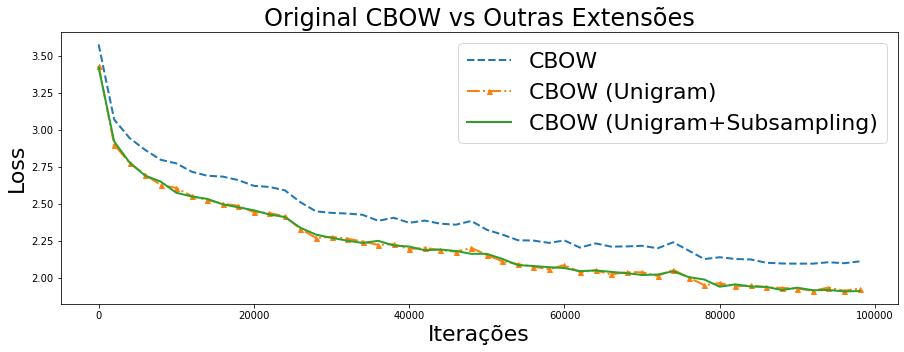

In [36]:
pylab.figure(figsize=(15,5))  # in inches

# Eixo x
x = np.arange(len(skip_gram_loss))*2000

# Plotting perda CBOW padrão, perda CBOW com amostragem unigram e
# perda CBOW com amostragem de unigramas + subamostragem, em um gráfico
pylab.plot(x, cbow_loss, label="CBOW",linestyle='--',linewidth=2)
pylab.plot(x, cbow_loss_unigram, label="CBOW (Unigram)",linestyle='-.',linewidth=2,marker='^',markersize=5)
pylab.plot(x, cbow_loss_unigram_subsampled, label="CBOW (Unigram+Subsampling)",linewidth=2)

# Legenda
pylab.title('Original CBOW vs Outras Extensões',fontsize=24)
pylab.xlabel('Iterações',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)

# Salva o plot
pylab.savefig('images/loss_cbow_vs_all_improvements.png')
pylab.show()

# Fim